In [2]:
# This module handles the projection of a catalog on a specific grid
# Adapted from the DESC WLMASSMAP code.

import numpy as np
#from scipy.stats import binned_statistic_2d
import healpy as hp
from astropy.table import Table
from kaiser_squires import flat_KS_map, healpix_KS_map
import matplotlib.pyplot as plt

# pixel resolution:
Nside=4096

#smoothing of the kappa maps, in arcmin:
sigma = 2.0

patch='N'

def eq2ang(ra, dec):
    """
    convert equatorial ra,dec in degrees to angular theta, phi in radians
    parameters

    ----------
    ra: scalar or array
        Right ascension in degrees
    dec: scalar or array
        Declination in degrees
    returns
    -------
    theta,phi: tuple
        theta = pi/2-dec*D2R # in [0,pi]
        phi   = ra*D2R       # in [0,2*pi]
    """
    dec = dec*np.pi/180
    ra  = ra*np.pi/180
    theta = np.pi/2 - dec
    phi  = ra
    return theta, phi

def project_healpix(catalog, nside, hp_type='RING'):
    """
    Adds a HEALpix pixel index to all galaxies in the catalog

    Parameters
    ----------
    catalog: table
        Input shape catalog

    nside: int
        HEALpix nside parameter

    hp_type: string
        HEALpix pixel order ('RING', 'NESTED')

    Returns
    -------
    catalog: table
        Output shape catalog with pixel index column
        nest will be either True or False depending on input
    """
    theta, phi = eq2ang(catalog['ra'], catalog['dec'])
    catalog['pixel_index'] = hp.ang2pix(nside, theta, phi,
                                        nest=(hp_type=='NESTED'))
    return catalog

def bin_shear_map(catalog, nx=None, ny=None, npix=None, sigtype=None, seed_id=None):
    """
    Computes the shear map by binning the catalog according to pixel_index.
    Either nx,ny or npix must be provided.
    
    Parameters
    ----------
    catalog: table
        Input shape catalog with pixel_index column

    nx,ny: int, optional
        Number of pixels of a 2d flat map
    
    npix: int, optional
        Number of pixels of a spherical map (or other 1D pixelating scheme)

    sigtype: type of observations 
        GG_noisefree    = cosmic shear noise-free
        GG_IA_noisefree = cosmic shear noise-free + IA
        GG_IA_noisy     = cosmic shear + IA + shapenoise
        pureIA          = pure IA 
        
    Returns
    -------
    gmap: ndarray
        Shear maps

    nmap: ndarray
        Number of galaxies per pixels
    """
    assert (npix is not None) or ((nx is not None) and (ny is not None))
    assert (sigtype is not None)

    # Bin the shear catalog
    if npix is None:
        npix = nx*ny

    if sigtype == 'GG_noisefree':
        str1 = 'g1';str2 = 'g2'
    if sigtype == 'GG_IA_noisy':
        str1 = 'e_obs_1';str2 = 'e_obs_2'
    if sigtype == 'GG_IA_noisefree':
        str1 = 'e_obs_no_noise_1';str2 = 'e_obs_no_noise_2'
    if sigtype == 'pureIA':
        str1 = 'e_IA_TATT_1';str2 = 'e_IA_TATT_2'
    if sigtype == 'HACC':
        str1 = 'gamma1';str2 = 'gamma2'
    if sigtype == 'KiDS':
        str1 = 'e1';str2 = 'e2'; strw = 'weight'

        
    #HACC/OuterRim:
    g1map = np.bincount(catalog['pixel_index'],
                        weights=catalog[str1],
                        minlength=npix)
    g2map = np.bincount(catalog['pixel_index'],
                        weights=catalog[str2],
                        minlength=npix)
    Nmap  = np.bincount(catalog['pixel_index'], minlength=npix)
    
    #KiDS
    '''
    g1map = np.bincount(catalog['pixel_index'],
                        weights=catalog[str1]*catalog[strw],
                        minlength=npix)
    g2map = np.bincount(catalog['pixel_index'],
                        weights=-catalog[str2]*catalog[strw],
                        minlength=npix)
    Nmap  = np.bincount(catalog['pixel_index'], weights=catalog[strw], minlength=npix)
    '''
    
    #KiDS-randoms, rotate ellipticity by random angle 'theta'
    '''
    rng = np.random.default_rng(seed=seed_id)
    theta = rng.random(np.shape(catalog[str1]))*2*np.pi
    #Randoms: eobs=cmplx(gamma1i(i)*cos(theta)-gamma2i(i)*sin(theta), (gamma1i(i)*sin(theta)+gamma2i(i)*cos(theta)))
    g1map = np.bincount(catalog['pixel_index'],
                        weights=catalog[str1]*catalog[strw]*np.cos(theta) - catalog[str2]*catalog[strw]*np.sin(theta),
                        minlength=npix)
    g2map = np.bincount(catalog['pixel_index'],
                        weights=catalog[str1]*catalog[strw]*np.sin(theta) + catalog[str2]*catalog[strw]*np.cos(theta),
                        minlength=npix)
    Nmap  = np.bincount(catalog['pixel_index'], weights=catalog[strw], minlength=npix)
    '''
    

    # Normalize by number of galaxies
    nz_ind = Nmap > 0
    g1map[nz_ind] /= Nmap[nz_ind]
    g2map[nz_ind] /= Nmap[nz_ind]

    gmap = np.stack([g1map,g2map], axis=0)

    return gmap, Nmap





In [2]:
nzshell=26
#for seed in range(30,31):
for i in range(1,6):
    #file = Table.read('../../GalCat/SRD-Y1/NLA/galcat_skysim5000_AIAp1_tomo{}.dat'.format(i), format='ascii')
    #file = Table.read('../../GalCat/SRD-Y1/NLA/galcat_skysim5000_AIAm1_tomo{}.dat'.format(i), format='ascii')
    #file = Table.read('../../GalCat/SRD-Y1/NLA/galcat_skysim5000_noIA_tomo{}.dat'.format(i), format='ascii')

    #file = Table.read('../../GalCat/SRD-Y1/deltaNLA/galcat_skysim5000_AIAp1_bta1_tomo{}.dat'.format(i), format='ascii')
    file = Table.read('../../GalCat/SRD-Y1/deltaNLA/galcat_skysim5000_noIA_bta1_tomo{}.dat'.format(i), format='ascii')
    #file = Table.read('../../GalCat/SRD-Y1/deltaNLA/galcat_skysim5000_AIAp1_bta2_tomo{}.dat'.format(i), format='ascii')
    #file = Table.read('../../GalCat/SRD-Y1/TT/galcat_skysim5000_C2p1_tomo{}.dat'.format(i), format='ascii')
    #file = Table.read('../../GalCat/SRD-Y1/TT/galcat_skysim5000_C2m1_tomo{}.dat'.format(i), format='ascii')
    #file = Table.read('../../GalCat/SRD-Y1/deltaTT/galcat_skysim5000_C2p1_bta1_tomo{}.dat'.format(i), format='ascii')
    #file = Table.read('../../GalCat/SRD-Y1/deltaTT/galcat_skysim5000_C2m1_bta1_tomo{}.dat'.format(i), format='ascii')
    #file = Table.read('../../GalCat/SRD-Y1/TATT/galcat_skysim5000_AIAp1_C2p1_bta1_tomo{}.dat'.format(i), format='ascii')
    #file = Table.read('../../GalCat/SRD-Y1/HODNLA/galcat_skysim5000_AIAp1_HOD_tomo{}.dat'.format(i), format='ascii')
    #file = Table.read('../../GalCat/SRD-Y1/HODTT/galcat_skysim5000_A2p1_HOD_tomo{}_TT.dat'.format(i), format='ascii')    
    #file = Table.read('/pscratch/sd/j/jmena/HOS_Sims/HACC150_3/shells_z{}_subsampledensitymax_nside8192/SRDv1_nz/kappa_hacc_seed{}_nside8192_catpoisson_imap{}.fits'.format(nzshell,seed,i-1), format='fits')    
    #file = Table.read('~/KiDS_Legacy'+patch+'_RA_DEC_e1_e2_w_notomo.dat', format='ascii')    
   

    print('got catalogue') 
    
    # Add pixel ID to the catalogue, to be used in healpix projection:
    file = project_healpix(file, nside=Nside)
    
    # construct shear maps:
    #gmap, nmap = bin_shear_map(file, npix=hp.nside2npix(Nside),sigtype='GG_noisefree')
    #gmap, nmap = bin_shear_map(file, npix=hp.nside2npix(Nside),sigtype='pureIA')
    #gmap, nmap = bin_shear_map(file, npix=hp.nside2npix(Nside),sigtype='GG_IA_noisefree')
    gmap, nmap = bin_shear_map(file, npix=hp.nside2npix(Nside),sigtype='GG_IA_noisy')
    #gmap, nmap = bin_shear_map(file, npix=hp.nside2npix(Nside),sigtype='HACC')
    #gmap, nmap = bin_shear_map(file, npix=hp.nside2npix(Nside),sigtype='KiDS', seed_id=seed)
    print('got shear maps') 

    # uncomment to display column names:
    #file.colnames
   
    #Kaiser and Squires transform on the sphere using healpix maps with 'Nside' resolution, and Gaussian smoothing
    # with width 'sigma'. Outputs are E- and B-mode maps
    kappa_e, kappa_b = healpix_KS_map(gmap, lmax = Nside, sigma=sigma)
    
    #show maps:
    """
    lonra = [40, 43]
    latra = [40, 43]
    hp.cartview(gmap[0,:], cbar=True, lonra=lonra, latra=latra,
            nest=False,
                title="g1",
                # min=-10, max=0,
                cmap=plt.cm.coolwarm,            
                norm=None, unit='$\gamma_1$')
    plt.show()
    hp.cartview(gmap[1,:], cbar=True, lonra=lonra, latra=latra,
            nest=False,
                title="g2",
                # min=-10, max=0,
                cmap=plt.cm.coolwarm,            
                norm=None, unit='$\gamma_2$')
    plt.show()
    hp.cartview(np.sqrt(gmap[0,:]**2 + gmap[1,:]**2), cbar=True, lonra=lonra, latra=latra,
            nest=False,
                title="gtot",
                # min=-10, max=0,
                cmap=plt.cm.coolwarm,            
                norm=None, unit='$\gamma_tot$')
    plt.show()
    hp.cartview(kappa_e, cbar=True, lonra=lonra, latra=latra,
            nest=False,
                title="gtot",
                # min=-10, max=0,
                cmap=plt.cm.coolwarm,            
                norm=None, unit='$\gamma_tot$')
    plt.show()
    hp.cartview(kappa_b, cbar=True, lonra=lonra, latra=latra,
            nest=False,
                title="gtot",
                # min=-10, max=0,
                cmap=plt.cm.coolwarm,            
                norm=None, unit='$\gamma_tot$')
    plt.show()
    """
    
    # Save kappa:
    #fname = '../../kappa/nz_SRD_KS/NLA/kappa_skysim5000_noIA_noisefree_tomo'+str(i)+'.dat'
    #fname = '../../kappa/nz_SRD_KS/NLA/kappa_skysim5000_noIA_noisy_tomo'+str(i)+'.dat'
    #fname = '../../kappa/nz_SRD_KS/NLA/kappa_skysim5000_noIA_noisefree_tomo'+str(i)+'_e2flip.dat'
    #fname = '../../kappa/nz_SRD_KS/NLA/kappa_skysim5000_noIA_noisefree_tomo'+str(i)+'_e1flip.dat'
    #fname = '../../kappa/nz_SRD_KS/NLA/kappa_skysim5000_noIA_noisefree_tomo'+str(i)+'_e1e2flip.dat'
    #fname = '../../kappa/nz_SRD_KS/NLA/kappa_skysim5000_NLA_AIAp1_noisefree_tomo'+str(i)+'.dat'
    #fname = '../../kappa/nz_SRD_KS/NLA/kappa_skysim5000_NLA_AIAp1_noisy_tomo'+str(i)+'.dat'
    #fname = '../../kappa/nz_SRD_KS/NLA/kappa_skysim5000_NLA_AIAm1_noisefree_tomo'+str(i)+'.dat'
    #fname = '../../kappa/nz_SRD_KS/deltaNLA/kappa_skysim5000_deltaNLA_AIAp1_bta1_noisefree_tomo'+str(i)+'.dat'
    #fname = '../../kappa/nz_SRD_KS/deltaNLA/kappa_skysim5000_deltaNLA_AIAp1_bta1_noisy_tomo'+str(i)+'.dat'
    fname = '../../kappa/nz_SRD_KS/deltaNLA/kappa_skysim5000_deltaNLA_noAI_bta1_noisy_tomo'+str(i)+'.dat'
    #fname = '../../kappa/nz_SRD_KS/deltaNLA/kappa_skysim5000_deltaNLA_noIA_bta1_noisefree_tomo'+str(i)+'.dat'
    #fname = '../../kappa/nz_SRD_KS/deltaNLA/kappa_skysim5000_deltaNLA_AIAp1_bta2_noisefree_tomo'+str(i)+'.dat'
    #fname = '../../kappa/nz_SRD_KS/TT/kappa_skysim5000_TT_C2p1_noisefree_tomo'+str(i)+'.dat'
    #fname = '../../kappa/nz_SRD_KS/TT/kappa_skysim5000_TT_C2p1_noisy_tomo'+str(i)+'.dat'
    #fname = '../../kappa/nz_SRD_KS/TT/kappa_skysim5000_TT_C2m1_noisefree_tomo'+str(i)+'.dat'
    #fname = '../../kappa/nz_SRD_KS/deltaTT/kappa_skysim5000_deltaTT_C2p1_bta1_noisefree_tomo'+str(i)+'.dat'
    #fname = '../../kappa/nz_SRD_KS/deltaTT/kappa_skysim5000_deltaTT_C2m1_bta1_noisefree_tomo'+str(i)+'.dat'
    #fname = '../../kappa/nz_SRD_KS/TATT/kappa_skysim5000_TATT_AIAp1_C2p1_bta1_noisefree_tomo'+str(i)+'.dat'
    #fname = '../../kappa/nz_SRD_KS/HODNLA/kappa_skysim5000_AIAp1_HODNLA_noisefree_tomo'+str(i)+'.dat'
    #fname = '../../kappa/nz_SRD_KS/HODTT/kappa_skysim5000_A2p1_HODTT_noisefree_tomo'+str(i)+'.dat'
    #fname = '../../../HACC-Y1/kappa-KS/nz_SRD_KS/kappa_nzshells'+str(nzshell)+'_seed'+str(seed)+'_tomo'+str(i)+'.dat'
    #fname = '../../../HACC-Y1/kappa-KS/nz_SRD_KS/kappa_KiDSN_notomo_E.dat'
    np.save(fname, kappa_e)
    #fname = '../../../HACC-Y1/kappa-KS/nz_SRD_KS/kappa_KiDSN_notomo_B.dat'
    #np.save(fname, kappa_b)

    #fname = '../../../HACC-Y1/kappa-KS/nz_SRD_KS/kappa_KiDS'+patch+'_notomo_E_e2flip_smooth'+str(int(sigma))+'.dat'
    #np.save(fname, kappa_e)
    #fname = '../../../HACC-Y1/kappa-KS/nz_SRD_KS/kappa_KiDS'+patch+'_notomo_B_e2flip_smooth'+str(int(sigma))+'.dat'
    #np.save(fname, kappa_b)

    #fname = '../../../HACC-Y1/kappa-KS/nz_SRD_KS/kappa_KiDS'+patch+'_notomo_ran_e2flip_smooth'+str(int(sigma))+'_seed'+str(seed)+'.dat'
    #np.save(fname, kappa_e)
    #fname = '../../../HACC-Y1/kappa-KS/nz_SRD_KS/kappa_KiDS'+patch+'_notomo_B_e2flip_smooth'+str(int(sigma))+'.dat'
    #np.save(fname, kappa_b)
    
    
    print("Saved", fname)

    # Save shear:
    #fname = '../../kappa/nz_SRD_KS/gamma_skysim5000_noIA_noisefree_tomo'+str(i)+'.dat'
    #np.save(fname, gmap)
    #print("Saved", fname)

    
    #print('Done tomobin ',i)
    #print('Done seed ',seed)

got catalogue
got shear maps


/global/cfs/cdirs/desc-wl/projects/wl-massmap/IA-infusion/SkySim5000/tools/SkySim5000_IA_infusion/kaiser_squires.py:53: RuntimeWarning: divide by zero encountered in divide
  almsE = alms[1]*((ell*(ell+1.))/((ell+2.)*(ell-1)))**0.5
/global/cfs/cdirs/desc-wl/projects/wl-massmap/IA-infusion/SkySim5000/tools/SkySim5000_IA_infusion/kaiser_squires.py:53: RuntimeWarning: invalid value encountered in multiply
  almsE = alms[1]*((ell*(ell+1.))/((ell+2.)*(ell-1)))**0.5
/global/cfs/cdirs/desc-wl/projects/wl-massmap/IA-infusion/SkySim5000/tools/SkySim5000_IA_infusion/kaiser_squires.py:54: RuntimeWarning: divide by zero encountered in divide
  almsB = alms[2]*((ell*(ell+1.))/((ell+2.)*(ell-1)))**0.5
/global/cfs/cdirs/desc-wl/projects/wl-massmap/IA-infusion/SkySim5000/tools/SkySim5000_IA_infusion/kaiser_squires.py:54: RuntimeWarning: invalid value encountered in multiply
  almsB = alms[2]*((ell*(ell+1.))/((ell+2.)*(ell-1)))**0.5
/global/cfs/cdirs/desc-wl/projects/wl-massmap/IA-infusion/SkySim5000/t

Saved ../../kappa/nz_SRD_KS/deltaNLA/kappa_skysim5000_deltaNLA_noAI_bta1_noisy_tomo1.dat
got catalogue
got shear maps
Saved ../../kappa/nz_SRD_KS/deltaNLA/kappa_skysim5000_deltaNLA_noAI_bta1_noisy_tomo2.dat
got catalogue
got shear maps
Saved ../../kappa/nz_SRD_KS/deltaNLA/kappa_skysim5000_deltaNLA_noAI_bta1_noisy_tomo3.dat
got catalogue
got shear maps
Saved ../../kappa/nz_SRD_KS/deltaNLA/kappa_skysim5000_deltaNLA_noAI_bta1_noisy_tomo4.dat
got catalogue
got shear maps
Saved ../../kappa/nz_SRD_KS/deltaNLA/kappa_skysim5000_deltaNLA_noAI_bta1_noisy_tomo5.dat


In [ ]:
#Make mask maps:
#hp.mollview(nmap, cbar=True, 
#        nest=False,
#            title="N_{gal}",
#            # min=-10, max=0,
#            cmap=plt.cm.coolwarm,            
#            norm=None, unit='N')
#plt.show()
hp.orthview(nmap,rot=(5,10),
                half_sky=True,
                title = "$N_{gal}$",
                cmap='bone',
            
               )
hp.orthview(kappa_e,rot=(5,10),
                half_sky=True,
                title = "$\kappa_{E}$",
                cmap='bone',
            
               )
hp.orthview(kappa_b,rot=(5,10),
                half_sky=True,
                title = "$\kappa_{B}$",
                cmap='bone',
            
               )

In [6]:
#Mask outside 0<RA< 20 and -36.61<Dec<0 deg (RA = phi, [0-90], DEC = theta, [0-360])
pix_id = np.arange(0,hp.nside2npix(4096))
theta, phi = hp.pix2ang(Nside, pix_id, nest=False, lonlat=True)


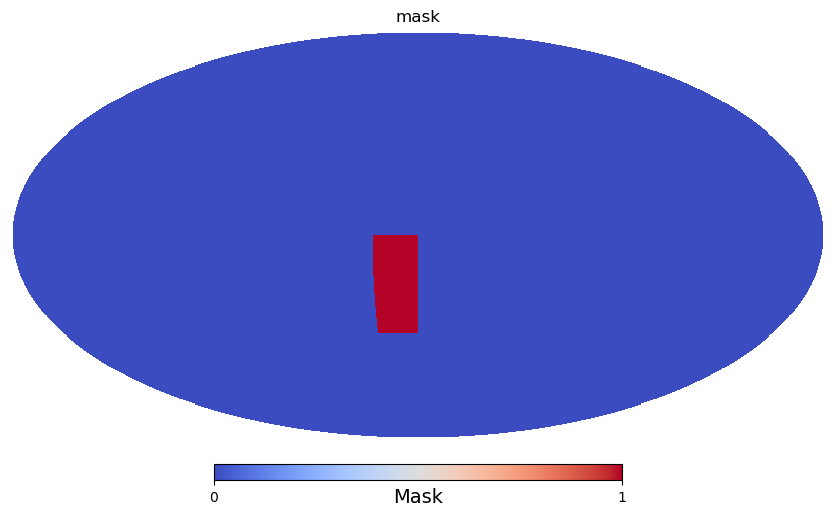

In [62]:
mask = np.zeros_like(pix_id)
mask[pix_id[theta<20]]+=1
mask[pix_id[phi<0]]+=1
mask[pix_id[phi>-36.61]]+=1
mask=np.floor(mask/3.0)

hp.mollview(mask, cbar=True, 
        nest=False,
            title="mask",
            # min=-10, max=0,
            cmap=plt.cm.coolwarm,            
            norm=None, unit='Mask')
plt.show()
#save
#fname = '../../kappa/nz_SRD_KS/HODTT/HOD_mask_4096.dat'
#np.save(fname, mask)

In [1]:
ls ../../kappa/nz_SRD_KS/deltaNLA/kappa_skysim5000_deltaNLA_AIAp1_bta1_noisy_tomo*

../../kappa/nz_SRD_KS/deltaNLA/kappa_skysim5000_deltaNLA_AIAp1_bta1_noisy_tomo1.dat.npy
../../kappa/nz_SRD_KS/deltaNLA/kappa_skysim5000_deltaNLA_AIAp1_bta1_noisy_tomo2.dat.npy
../../kappa/nz_SRD_KS/deltaNLA/kappa_skysim5000_deltaNLA_AIAp1_bta1_noisy_tomo3.dat.npy
../../kappa/nz_SRD_KS/deltaNLA/kappa_skysim5000_deltaNLA_AIAp1_bta1_noisy_tomo4.dat.npy
../../kappa/nz_SRD_KS/deltaNLA/kappa_skysim5000_deltaNLA_AIAp1_bta1_noisy_tomo5.dat.npy


In [1]:
ls  ../../kappa/nz_SRD_KS/deltaNLA/kappa_skysim5000_deltaNLA_noIA_bta1_noisefree*

../../kappa/nz_SRD_KS/deltaNLA/kappa_skysim5000_deltaNLA_noIA_bta1_noisefree_tomo1.dat.npy


In [18]:
max(theta)

359.989013671875

In [29]:
mask[pix_id[theta<20] and pix_id[phi>90]] = 1

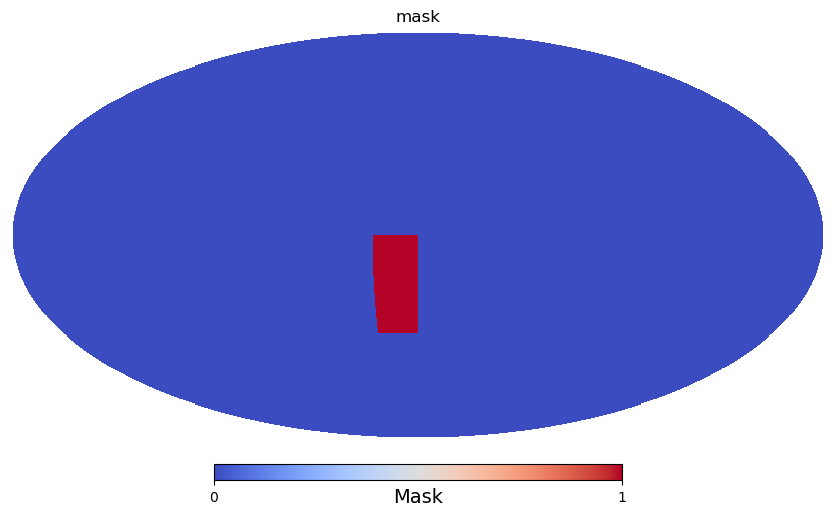

In [ ]:
mask = np.zeros_like(nmap)
#mask[pix_id[nmap>0]]+=1
mask[nmap>0]+=1

hp.mollview(mask, cbar=True, 
        nest=False,
            title="mask",
            # min=-10, max=0,
            cmap=plt.cm.coolwarm,            
            norm=None, unit='Mask')
plt.show()
fname = '../../../HACC-Y1/kappa-KS/nz_SRD_KS/mask_KiDS'+patch+'.dat'
np.save(fname, mask)


In [1]:
ls ../../../HACC-Y1/kappa-KS/nz_SRD_KS/mask_KiDS*

../../../HACC-Y1/kappa-KS/nz_SRD_KS/mask_KiDSN.dat.npy
../../../HACC-Y1/kappa-KS/nz_SRD_KS/mask_KiDSS.dat.npy


In [9]:
data = np.array((1,2,3,4))

In [6]:
data


array([1, 2, 3, 4])

In [7]:
np.shape(data)

(4,)

In [10]:
data[[3,1,2,0]]

array([4, 2, 3, 1])

In [11]:
value = list(data)

In [12]:
value

[1, 2, 3, 4]

In [4]:
hp.nside2resol(8192)*180/np.pi*60

0.42943580147717575